##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup

Follow the instructions in the [README](README.md) of this repo to install the required packages on the base AI Platform Notebooks TF 2.4 image.

## Tutorial

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

## Configuring input pipelines

### Download the IMDB dataset

Let's download and extract the dataset.

#### Prepare local directory


In [3]:
local_dir = os.path.expanduser('~')
local_dir = f'{local_dir}/datasets'

if tf.io.gfile.exists(local_dir):
    tf.io.gfile.rmtree(local_dir)
tf.io.gfile.makedirs(local_dir)

!ls -la {local_dir}

total 8
drwxr-xr-x  2 jupyter jupyter 4096 Feb 28 20:04 .
drwxr-xr-x 18 jupyter jupyter 4096 Feb 28 20:04 ..


#### Download the dataset

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
local_path = f'{local_dir}/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file(local_path, url,
                                  untar=True, 
                                  cache_dir=local_dir,
                                  cache_subdir='.'
                                  )
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 2s 0us/step


### Set up input pipelines
Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [5]:
def create_input_pipelines(train_dir, test_dir, val_split, seed, batch_size):
    
    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        train_dir,
        batch_size=batch_size,
        validation_split=val_split,
        subset='training',
        seed=seed)

    class_names = raw_train_ds.class_names
    train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        train_dir,
        batch_size=batch_size,
        validation_split=val_split,
        subset='validation',
        seed=seed)

    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        test_dir,
        batch_size=batch_size)

    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names


In [7]:
batch_size = 64
seed = 42
val_split = 0.2
test_dir = f'{dataset_dir}/test'

train_ds, val_ds, test_ds, class_names = (
    create_input_pipelines(train_dir, test_dir, val_split, seed, batch_size)
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [8]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"First of all, I liked very much the central idea of locating the '' intruders'', Others in the fragile Self, on various levels - mainly subconscious but sometimes more allegorical. In fact the intruders are omnipresent throughout the film : in the Swiss-French border where the pretagonist leads secluded life; in the his recurring daydream and nightmare; inside his ailing body after heart transplantation.... In the last half of the film, he becomes intruder himself, returning in ancient french colony in the hope of atoning for the past. <br /><br />The overall tone is bitter rather than pathetic, full of regrets and guilts, sense of failure being more or less dominant. This is a quite grim picture of an old age, ostensibly self-dependent but hopelessly void and lonely inside. The directer composes the images more to convey passing sensations of anxiety and desire than any explicit meanings. Some of them are mesmerizing, not devoid of humor though, kind of absurdist play only s

## Creating a model 
### Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL.

In this notebook we will use one of the classic BERT models with L=12 hidden layers, a hidden size of H=768, and A=12 attention heads. This [TF Hub model](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) uses the implementatio of BERT from the [TensorFlow Model Garden repository](https://github.com/tensorflow/models/tree/master/official/nlp/bert). 



In [10]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [11]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [12]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

##### Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.92169905 -0.39353544 -0.53932065  0.6825632   0.43848684 -0.14021216
  0.8774716   0.26043403 -0.63113207 -0.9999657  -0.2632019   0.8510541 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451521  0.25141707  0.19074991 ... -0.24845055  0.3856859
   0.13291013]
 [-0.59478724 -0.3942039   0.25245732 ... -0.7694684   1.1564159
   0.32475767]
 [ 0.00641547 -0.15766479  0.5461029  ... -0.17451122  0.6028951
   0.42672256]
 ...
 [ 0.21948367 -0.20927016  0.5386838  ...  0.24693456  0.18250936
  -0.44426975]
 [ 0.01080247 -0.44553152  0.35991025 ...  0.31722748  0.23562762
  -0.6307049 ]
 [ 0.29321158 -0.10581823  0.6114763  ...  0.20745681  0.14494625
  -0.3535329 ]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

#### Defining your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can use just follow the model's url for documentation. Here specifically you don't need to worry about it because the preprocessing model will take care of that for you.


In [15]:
def build_classifier_model(tfhub_handle_preprocess, tfhub_handle_encoder):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

Since we are running on a multi-GPU node we are going to use distributed training.

The `tf.distribute.Strategy` API provides an abstraction for distributing your training
across multiple processing units. The goal is to allow users to enable distributed training using existing models and training code, with minimal changes.

This tutorial uses the `tf.distribute.MirroredStrategy`, which
does in-graph replication with synchronous training on many GPUs on one machine.
Essentially, it copies all of the model's variables to each processor.
Then, it uses [all-reduce](http://mpitutorial.com/tutorials/mpi-reduce-and-allreduce/) to combine the gradients from all processors and applies the combined value to all copies of the model.

`MirroredStrategy` is one of several distribution strategy available in TensorFlow core. You can read about more strategies at [distribution strategy guide](../../guide/distributed_training.ipynb).

`tf.distribute.Strategy` is integrated into `tf.keras`.  By integrating into `tf.keras` backend, we've made it seamless for you to distribute your training written in the Keras training framework using `model.fit`.

To use distributed startegy with `tf.keras` you will:

1. Create an instance of the  `tf.distributeMirrored`.
2. Create the model, optimizer and metrics inside `strategy.scope`.


### Loss function and metrics

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `tf.keras.losses.BinaryCrossentropy` loss function and `tf.metrics.BinaryAccuracy` metric.


### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).



In [16]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = build_classifier_model(tfhub_handle_preprocess, tfhub_handle_encoder)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    optimizer = optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw')

    model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

### Global batch size

When using the `MirroredStrategy`, each batch of the given input is divided equally among the multiple replicas. For instance, if using `MirroredStrategy` with 2 GPUs, each batch of size 64 will get divided among the 2 GPUs, with each receiving 32 input examples in each step.  Recall that we set the batch size of our datasets to 64. This will be a good size for a two GPU node. If you are on a node with more GPUs you may want to increase the batch size.

### Train the model

You can now start training of the model.

You can use the `nvidia-smi` tool to verify that all GPUs on the node are active. The `nvidia-smi` tool is pre-installed on AI Platform Notebooks. To start the `nvidia-smi` to continuously monitor the GPU's ecxecute the following command from the terminal window:

```
nvidia-smi -l 2
```

In [17]:
history = model.fit(x=train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/2
313/313 [==============================] - 387s 1s/step - loss: 0.5069 - binary_accuracy: 0.7049 - val_loss: 0.2961 - val_binary_accuracy: 0.8754
Epoch 2/2
313/313 [==============================] - 354s 1s/step - loss: 0.2517 - binary_accuracy: 0.8922 - val_loss: 0.3119 - val_binary_accuracy: 0.8806


## Evaluate the model

The training is done. Let's see how the model performs on the test dataset. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [18]:
loss, accuracy = model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

391/391 [==============================] - 138s 353ms/step - loss: 0.2923 - binary_accuracy: 0.8835
Loss: 0.29226037859916687
Accuracy: 0.8835200071334839


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


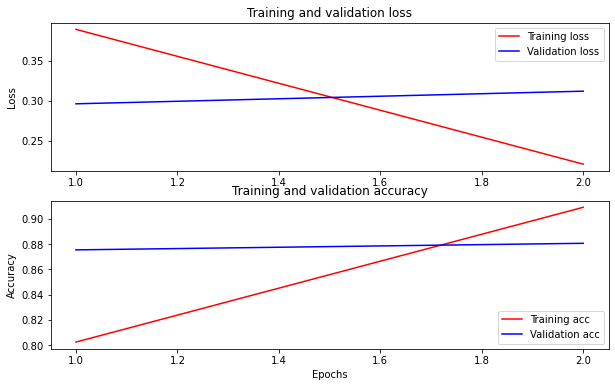

In [19]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
saved_model_path = '{}/models/imdb_bert'.format(
    os.path.expanduser('~'))

model.save(saved_model_path, include_optimizer=False)

Let's reload the model so you can try it side by side with the model that is still in memory.

In [24]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [25]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

NameError: name 'classifier_model' is not defined

If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu) which runs on a TPU and shows you how to work with multiple inputs.